## Measuring and predicting locality of smartphone memory access through data mining of trace files
### IITGN CS612 Fall 2017 - Project Checkpoint Presentation (13 November 2017)
### Sohhom Bandyopadhyay (15510011) and Sujata Sinha (15350008)

**Based on trace files from: ** <br>
http://iotta.snia.org/tracetypes/3 (Traces collected from **Nexus 5**) <br>
Zhou, D., Pan, W., Wang, W., & Xie, T. (2015, October). I/O characteristics of smartphone applications and their implications for eMMC design. In Workload Characterization (IISWC), 2015 IEEE International Symposium on (pp. 12-21). IEEE.



** Outline (this notebook):**
This notebook presents the code and outputs of some preliminary EDA (Exploratory Data Analysis). Sections:
 - Description of trace file format
 - Conversion and data preprocessing
 - Calculate turnaround time and hardware processing time for each access, based on timestamps
 - plots of:
    - Average request size (bytes) by type of activity
    - Average turnaround time (microseconds) by type of activity
    - Average hardware time (microseconds) by type of activity
    

** ToDo (next two weeks): ** <br>
 - measuring spatial and temporal locality
 - Machine learning classifier to predict the above

## Trace file format:
**column 0** : start address (in sectors) <br>
**column 1** : access size (in sectors) <br>
**column 2** : access size (in byte) <br>
**column 3** : access type & waiting status (3 bit number):
 - LSB: indicates read (0) or write (1)
 - MSB: indicates waiting status (0 = yes, 1 = no)
 - Middle bit: unused <br>
 (It's not represented as binary, but as integers : 0, 1, 4 and 5 )
 <br>
 
**column 4** : request generate time (generated and inserted into request queue). <br>
**column 5** : request process start time (fetched and and began processing)  <br>
**column 6** : request submit time (submitted to hardware) <br>
**column 7** : request finish time (completed, callback function invoked)  <br>

Thus, any request goes through 4 stages: push to queue -> start processing -> submit to hardware -> finish (callback)


In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 9]

In [2]:
# define where the trace files, w.r.t working directory
data_dir = 'Trace_files'
# collect the names of all txt files in specified directory
fnames = [x for x in filter(lambda x: x.endswith('.txt'), os.listdir(os.path.join('.', data_dir)))]
# extract the names of workloads from file names, this will be useful later to create dictionary keys
workload_names = [ x for x in map(lambda x: x.split('_')[1].split('.')[0], fnames) ]

In [3]:
# read all the Trace Files into a single variable called dataset
# it's dict of dataframes, indexed by name
# example: dataset['twitter'] gives all rows of the file "log186_twitter.txt"
dataset = {fname.split('_')[1].split('.')[0]:pd.read_csv(os.path.join(data_dir, fname), delimiter='\s+', header = None, dtype = float) for fname in fnames}

## convert unix timestamps to datetime objects
This will help with time difference calculation

In [4]:
# columns 4 through 7 contains the timestamps (floating point numbers), need to convert them into manipulable objects
for cindx in 4, 5, 6, 7:
    for df in dataset.values():
        # apply transformation (non destructive) to each column, then store the updated column back in the dataframe
        df.loc[:,cindx] = df.loc[:,cindx].apply(datetime.fromtimestamp)

### Calculate durations
 ... of various processing stages

In [5]:
# initialize empty dictionaries, will be indexed by workload names
# refer to trace file format for details
# e.g turnaround_time['twitter'] gives a vector of same length as trace file, containing the TaT for each request
turnaround_time = {}
hw_time = {}
for name in workload_names:
    # TaT = finish time (column 7) - submission time (column 4)
    turnaround_time[name] = dataset[name].iloc[:,7] - dataset[name].iloc[:,4]
    turnaround_time[name] = turnaround_time[name].apply(lambda x: x.components.milliseconds*1000+x.components.microseconds)
    # hardware processing time = finish time (column 7) - hardware submit time (column 6)
    hw_time[name] = dataset[name].iloc[:,7] - dataset[name].iloc[:,6]
    hw_time[name] = hw_time[name].apply(lambda x: x.components.milliseconds*1000+x.components.microseconds)

### Plot averages across activities
Just as a preliminary exploration, we are interested in finding out the relative magnitudes across workloads

#### Plot 1

In [6]:
# extract the request sizes for each activity
# dictionary indexed by workload names, each element a numpy ndarray
# e.g request_sizes['twitter'] gives the request size (in bytes) of all requests in that trace file
request_sizes = { workname:dataset[workname].iloc[:,2] for workname in workload_names }
# calculate the average across all workloads, again a dictionary indexed by workload names
avg_req_size = {x:np.mean(request_sizes[x]) for x in workload_names}

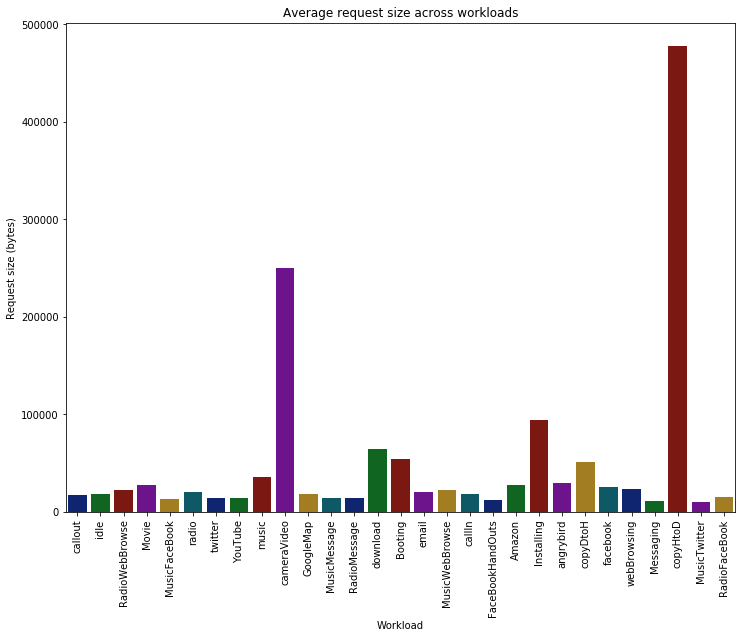

In [7]:
# plotting..
somevar = seaborn.barplot(list(avg_req_size.keys()), list(avg_req_size.values()), palette='dark')
for item in somevar.get_xticklabels():
    item.set_rotation(90)
plt.ylabel('Request size (bytes)')
plt.xlabel('Workload')
plt.title("Average request size across workloads")
plt.show()

#### Plot 2

In [8]:
# TO be plotted
# calculate the average turnaround time (request finish - request submission) across all workloads
avg_tat = {x:np.mean(turnaround_time[x]) for x in workload_names}

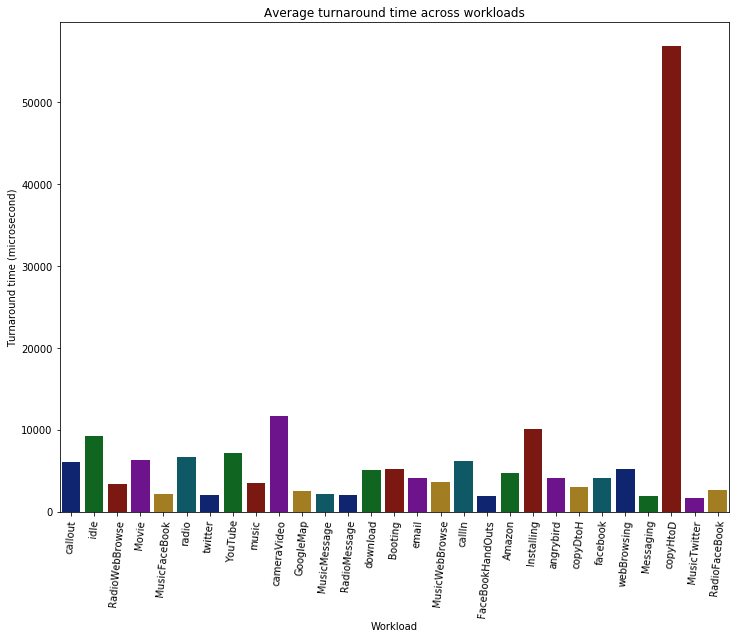

In [9]:
# plotting..
axes = seaborn.barplot(list(avg_tat.keys()), list(avg_tat.values()), palette='dark')
for item in axes.get_xticklabels():
    item.set_rotation(85)
plt.title("Average turnaround time across workloads")
plt.xlabel('Workload')
plt.ylabel('Turnaround time (microsecond)')
plt.show()

#### Plot 3

In [10]:
# TO be plotted
# calculate the average time taken by hardware to process request, across all workloads
avg_hw = {x:np.mean(hw_time[x]) for x in workload_names}

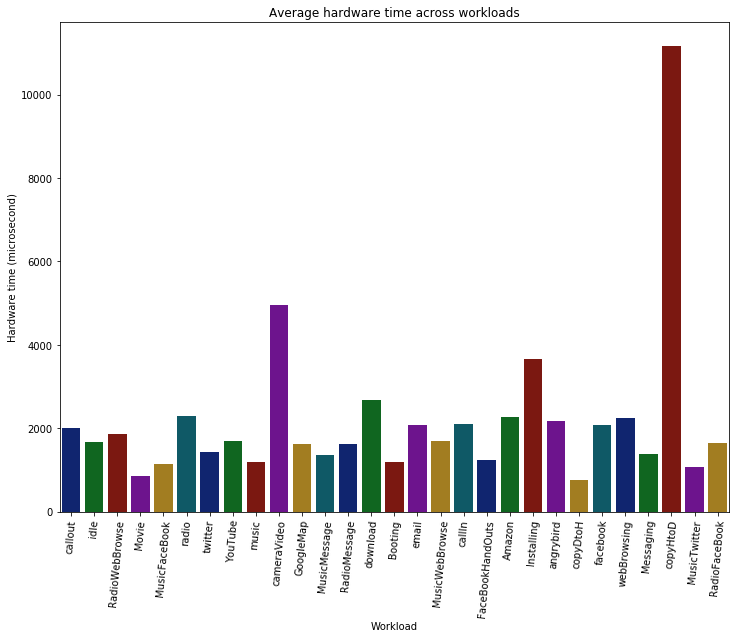

In [11]:
# plotting..
axes = seaborn.barplot(list(avg_hw.keys()), list(avg_hw.values()), palette='dark')
for item in axes.get_xticklabels():
    item.set_rotation(85)
plt.title("Average hardware time across workloads")
plt.xlabel('Workload')
plt.ylabel('Hardware time (microsecond)')
plt.show()

## Todo

### Some interesting questions :

  - How many unique sector requests?
  - Does request size correlate with the time taken to service it?
  - How many repeated requests within a certain threshold of time (e.g. 5ms)?
  - Assuming a certain cache size and configuration, how many bytes could have been cached?
 

#### Plot 4 (fraction of unique sector requests)

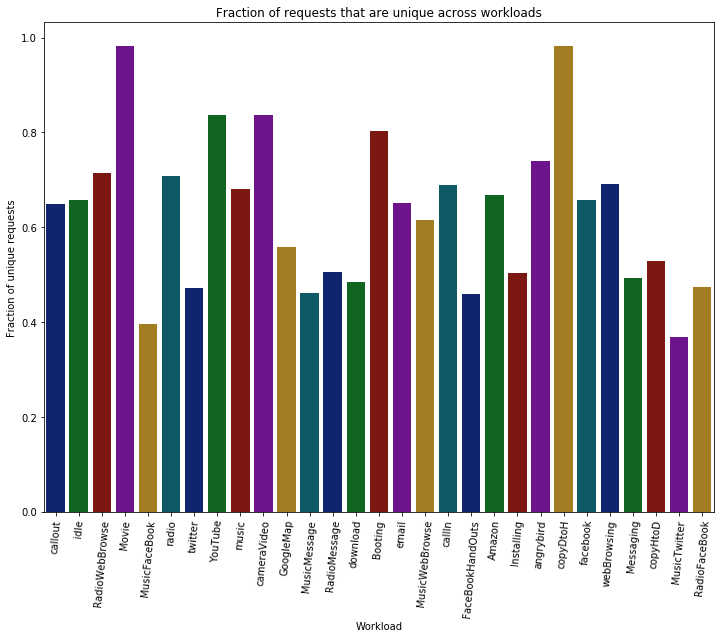

In [12]:
# calculate and plot number of unique sectors across workloads
unique_fraction = {key:dataset[key].iloc[:,0].unique().shape[0] / dataset[key].shape[0] for key in workload_names}
# plot them..
axes = seaborn.barplot(list(unique_fraction.keys()), list(unique_fraction.values()), palette='dark')
for item in axes.get_xticklabels():
    item.set_rotation(85)
plt.title("Fraction of requests that are unique across workloads")
plt.xlabel('Workload')
plt.ylabel('Fraction of unique requests')
plt.show()

#### Plot 5 (corelation of request size with hardware processing time)

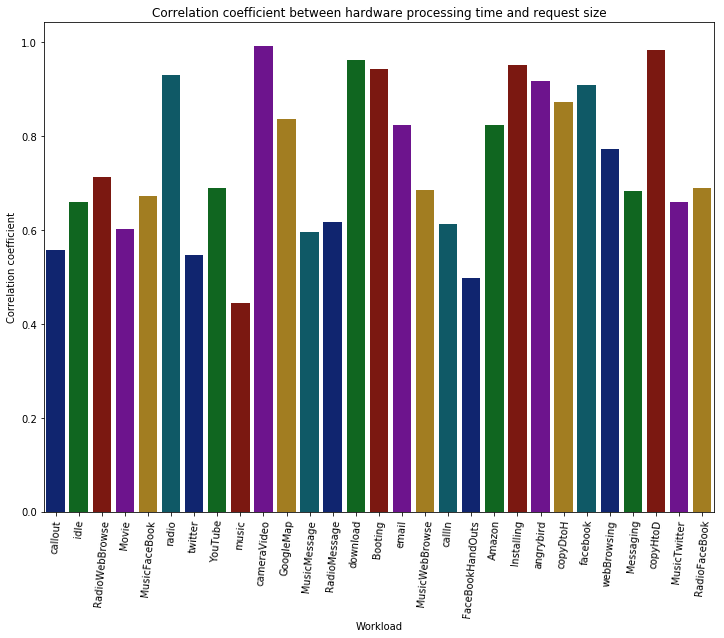

In [13]:
# correlate request size with hardware processing time (i.e, ignore the queue waiting, if any)
corrcoefs_reqsize_hwtime = {key:hw_time[key].corr(request_sizes[key]) for key in workload_names}
# plotting
axes = seaborn.barplot(list(corrcoefs_reqsize_hwtime.keys()), list(corrcoefs_reqsize_hwtime.values()), palette='dark')
for item in axes.get_xticklabels():
    item.set_rotation(85)
plt.title("Correlation coefficient between hardware processing time and request size")
plt.xlabel('Workload')
plt.ylabel('Correlation coefficient')
plt.show()

### towards locality..
For a given workload, for each sector that was requested **more than once**, what are the **time-deltas between first request and subsequent requests?**

In [14]:
df = dataset['radio']

In [15]:
uniq_sectors = df.iloc[:,0].unique()

In [16]:
uniq_sectors.shape

(4122,)

In [17]:
5820-1698

4122